In [ ]:
## Part 2 — Model Training and Fairness Evaluation

In [5]:
from part1 import load_and_clean, prepare

Accuracy: 0.846
Precision: 0.736
Recall: 0.588
F1-score: 0.653
Demographic Parity Difference: 0.177
Equal Opportunity Difference: 0.113
Calibration (Brier score): 0.106


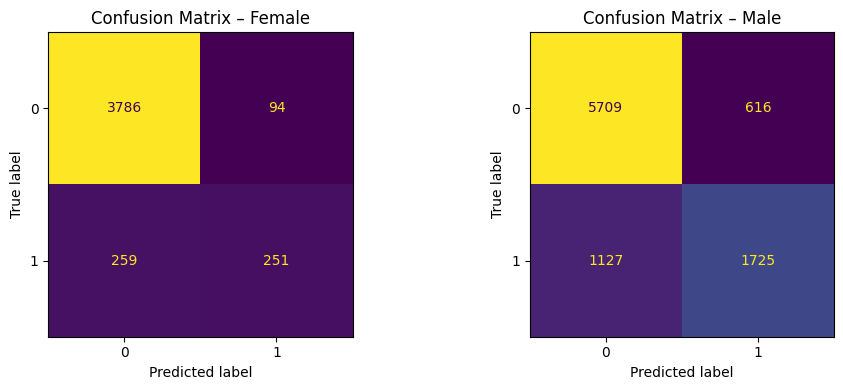

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, confusion_matrix, ConfusionMatrixDisplay
)
from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference
import matplotlib.pyplot as plt

# Use Part 1 helpers
df = load_and_clean("data")
df = prepare(df)

# Features/target
target = "y"
sensitive_series = df["sex"]
X = df.drop(columns=["income", target, "sex", "sex_male"], errors="ignore")
y = df[target]

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_series, test_size=0.30, random_state=42, stratify=y
)

# Preprocess
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

clf = Pipeline([
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=1000)),
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Required metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0):.3f}")

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=s_test)
eo_diff = equal_opportunity_difference(y_test, y_pred, sensitive_features=s_test)
print(f"Demographic Parity Difference: {dp_diff:.3f}")
print(f"Equal Opportunity Difference: {eo_diff:.3f}")

# Calibration (overall)
print(f"Calibration (Brier score): {brier_score_loss(y_test, y_prob):.3f}")

# Confusion matrices by subgroup
groups = sorted(s_test.unique())
fig, axes = plt.subplots(1, len(groups), figsize=(5*len(groups), 4))
if len(groups) == 1:
    axes = [axes]

for ax, g in zip(axes, groups):
    mask = (s_test == g)
    cm = confusion_matrix(y_test[mask], y_pred[mask], labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix – {g}")

plt.tight_layout()
plt.show()
